<a href="https://colab.research.google.com/github/ThierrryScotto/Air-Passengers-Forecast/blob/main/air_passengers_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [5]:
dataset = pd.read_csv("/content/AirPassengers.csv")

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


### Parse strings to datetype

In [7]:
dataset['Month'] = pd.to_datetime(dataset['Month'], infer_datetime_format=True)
indexed_dataset = dataset.set_index(['Month'])

In [8]:
indexed_dataset

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [9]:
from datetime import datetime
indexed_dataset.head(5)

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### plot graph

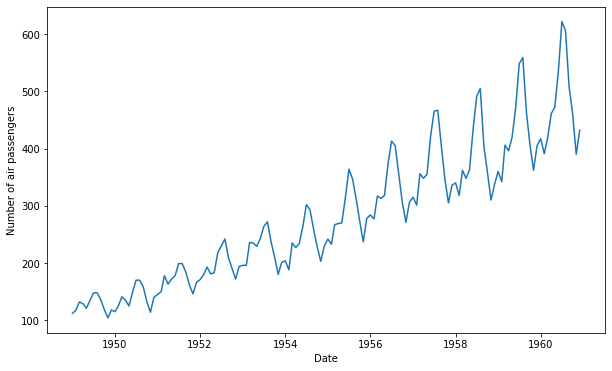

In [10]:
plt.xlabel("Date")
plt.ylabel("Number of air passengers")
plt.plot(indexed_dataset)

## Determining rolling statistics

In [11]:
rolmean = indexed_dataset.rolling(window=12).mean()
rolstd = indexed_dataset.rolling(window=12).std()
print(rolmean, rolstd)

            Passengers
Month                 
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
...                ...
1960-08-01  463.333333
1960-09-01  467.083333
1960-10-01  471.583333
1960-11-01  473.916667
1960-12-01  476.166667

[144 rows x 1 columns]             Passengers
Month                 
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
...                ...
1960-08-01   83.630500
1960-09-01   84.617276
1960-10-01   82.541954
1960-11-01   79.502382
1960-12-01   77.737125

[144 rows x 1 columns]


### Plot rolling statistics

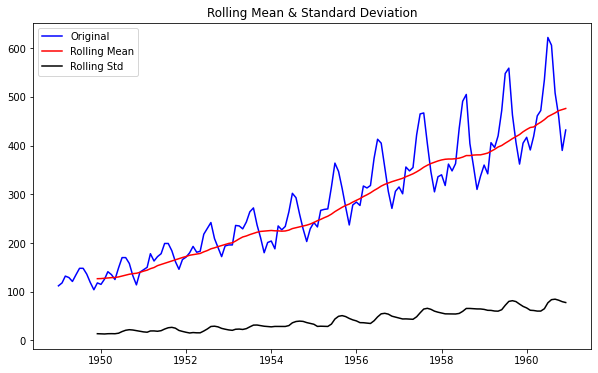

In [12]:
orig = plt.plot(indexed_dataset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

## Perform Dickey-Fuller test

In [13]:
from statsmodels.tsa.stattools import adfuller

print('Result of Dickey-Fuller Test')
df_test = adfuller(indexed_dataset['Passengers'], autolag='AIC')

df_output = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations used'])
for key, value in df_test[4].items():
  df_output['Critical Value (%s)'%key] = value

print(df_output)

Result of Dickey-Fuller Test
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


### Estimating trend

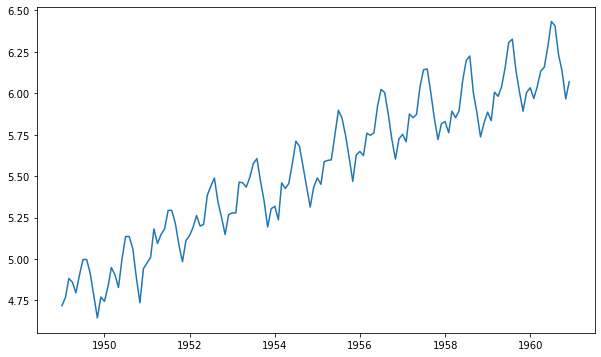

In [14]:
indexed_dataset_log_scale = np.log(indexed_dataset)
plt.plot(indexed_dataset_log_scale)

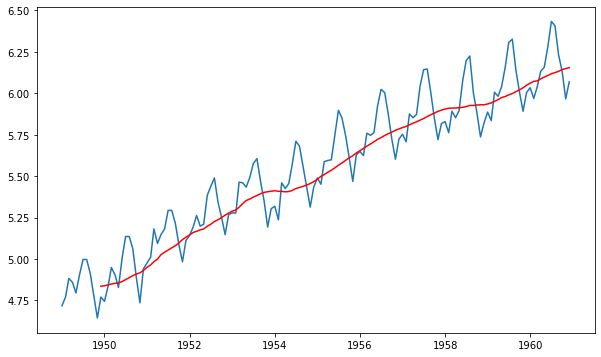

In [15]:
moving_average = indexed_dataset_log_scale.rolling(window=12).mean()
moving_std = indexed_dataset_log_scale.rolling(window=12).std()
plt.plot(indexed_dataset_log_scale)
plt.plot(moving_average, color='red')

## Turning into stationary

In [16]:
dataset_log_scaled_minus_moving_average = indexed_dataset_log_scale - moving_average
dataset_log_scaled_minus_moving_average.head(5)

,Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN


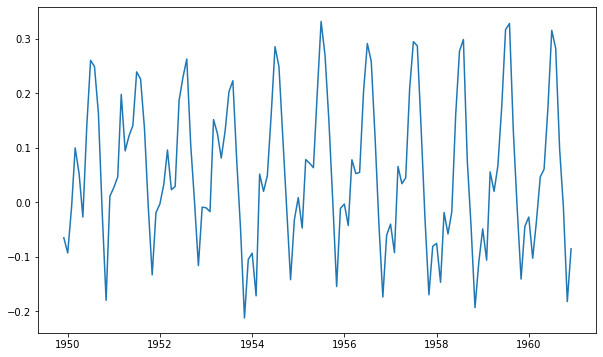

In [17]:
plt.plot(dataset_log_scaled_minus_moving_average)

### Removing Nan value

In [18]:
dataset_log_scaled_minus_moving_average.dropna(inplace=True)
dataset_log_scaled_minus_moving_average.head(5)

,Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142


In [19]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(time_series):
  # Determining rolling statistics
  moving_average = time_series.rolling(window=12).mean()
  moving_std = time_series.rolling(window=12).std()

  # Plot rolling statistics
  orig = plt.plot(time_series, color='blue', label='Original')
  med = plt.plot(moving_average, color='red', label='Rolling Mean')
  std = plt.plot(moving_std, color='black', label='Rolling STD')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)

  # perform Dickey-Fuller test
  print('Result of Dickey-Fuller test:')
  df_test = adfuller(time_series['Passengers'], autolag='AIC')
  df_output = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations used'])
  for key, value in df_test[4].items():
    df_output['Critical Value (%s)'%key] = value
  print(df_output)

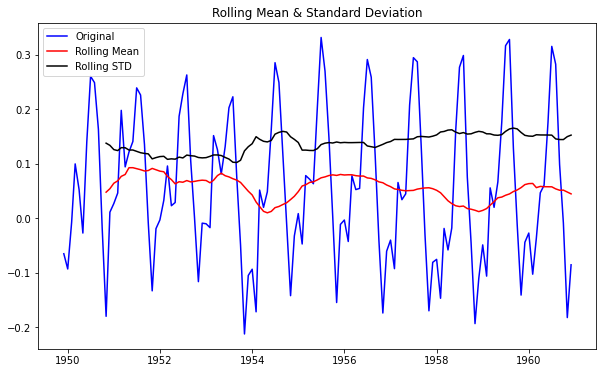

Result of Dickey-Fuller test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [20]:
test_stationarity(dataset_log_scaled_minus_moving_average)

## Weighted average to see the trend

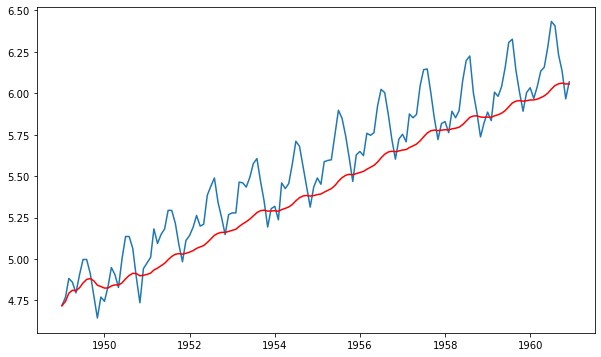

In [21]:
exponential_decay_weighted_average = indexed_dataset_log_scale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexed_dataset_log_scale)
plt.plot(exponential_decay_weighted_average, color='red')

### Subtracting the weighted average

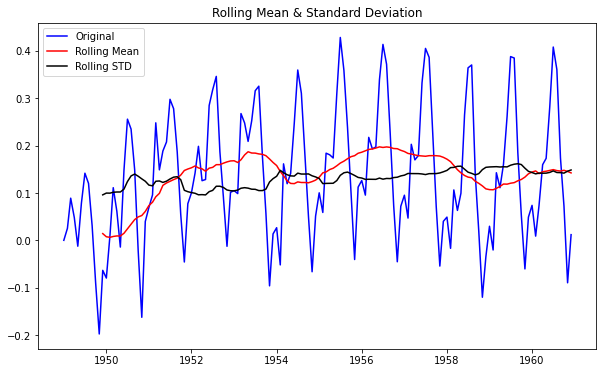

Result of Dickey-Fuller test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [22]:
dataset_log_scale_minus_moving_exponential_decay_average = indexed_dataset_log_scale - exponential_decay_weighted_average
test_stationarity(dataset_log_scale_minus_moving_exponential_decay_average)

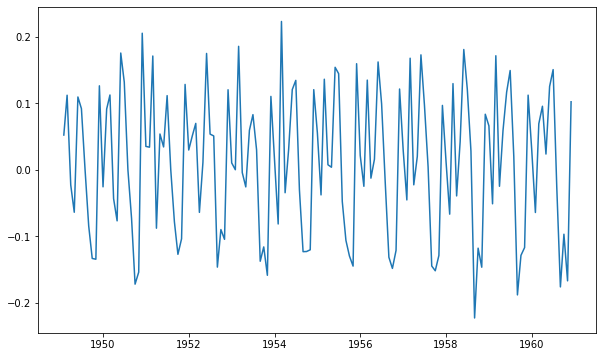

In [23]:
dataset_log_diff_shifting = indexed_dataset_log_scale - indexed_dataset_log_scale.shift()
plt.plot(dataset_log_diff_shifting)

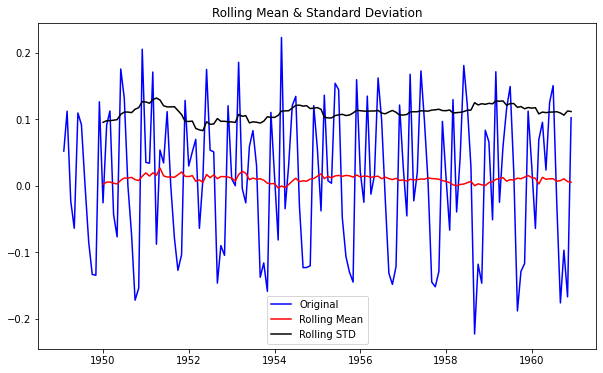

Result of Dickey-Fuller test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [24]:
dataset_log_diff_shifting.dropna(inplace=True)
test_stationarity(dataset_log_diff_shifting)

## Decompose

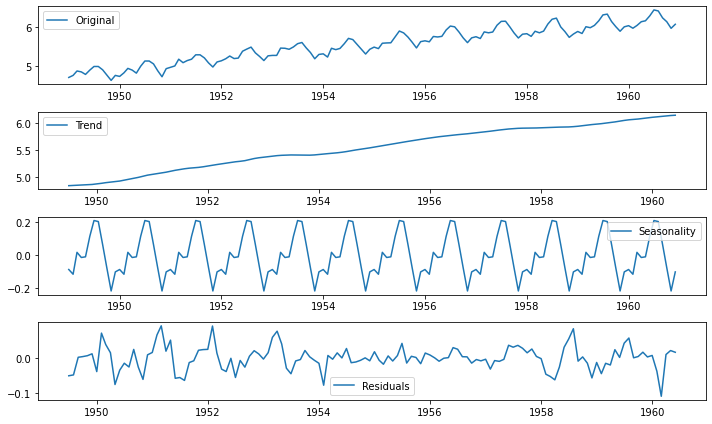

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(indexed_dataset_log_scale)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexed_dataset_log_scale, label="Original")
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label="Trend")
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label="Seasonality")
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label="Residuals")
plt.legend(loc='best')
plt.tight_layout()

decomposed_log_data = residual
decomposed_log_data.dropna(inplace=True)
# test_stationarity(decomposed_log_data)

Residual plot

In [26]:
decomposed_log_data = residual
decomposed_log_data.dropna(inplace=True)
# test_stationarity(decomposed_log_data)

p = Autoregressive delay value. (PACF chart)<br/>
q = Moving average value. (ACF chart)
<p/>
ACF: Autocorrelation graph<br/>
PACF: Partial autocorrelation graph

## Autocorrelation plot

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


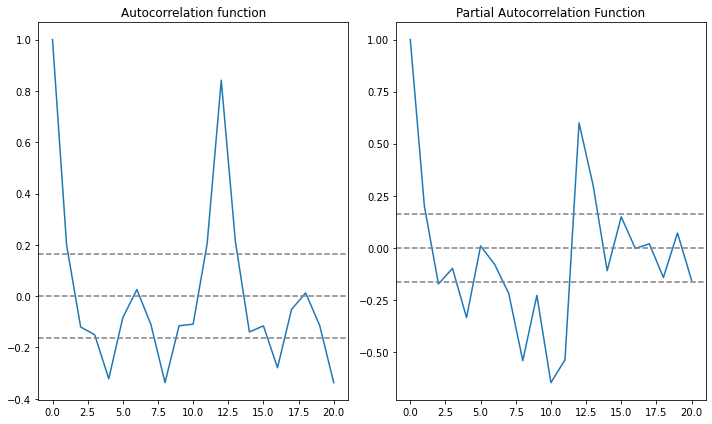

In [27]:
# ACF and PACF
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(dataset_log_diff_shifting, nlags=20)
lag_pacf = pacf(dataset_log_diff_shifting, nlags=20, method='ols')

# Plot ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dataset_log_diff_shifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dataset_log_diff_shifting)), linestyle='--', color='gray')
plt.title('Autocorrelation function')

# Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dataset_log_diff_shifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dataset_log_diff_shifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

## Training the model

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be us

Plotting AR model


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


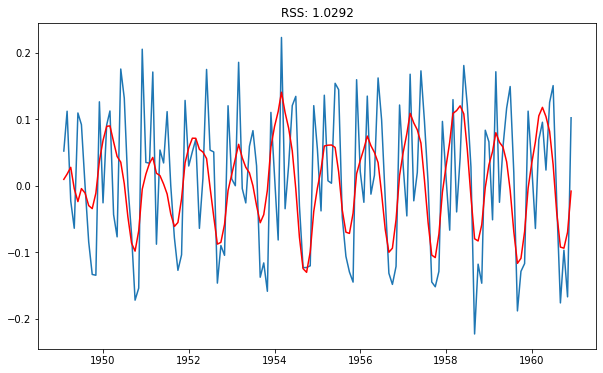

In [28]:
from statsmodels.tsa.arima_model import ARIMA

# AR MODEL
model = ARIMA(indexed_dataset_log_scale, order=(2, 1, 2))
results_AR = model.fit(disp=-1)
plt.plot(dataset_log_diff_shifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues - dataset_log_diff_shifting['Passengers'])**2))
print('Plotting AR model')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting AR model


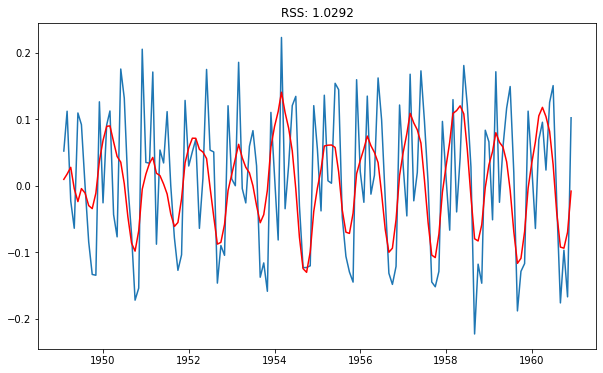

In [29]:
# MA MODEL
model = ARIMA(indexed_dataset_log_scale, order=(0, 1, 2))
results_MA = model.fit(disp=-1)
plt.plot(dataset_log_diff_shifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues - dataset_log_diff_shifting['Passengers'])**2))
print('Plotting AR model')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Plotting AR model


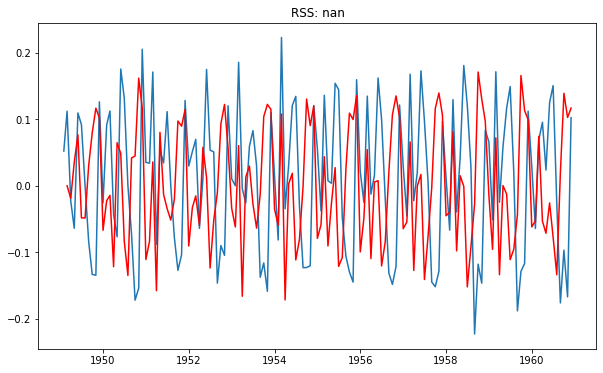

In [30]:
model = ARIMA(indexed_dataset_log_scale, order=(2, 2, 2))
results_ARIMA = model.fit(disp=-1)
plt.plot(dataset_log_diff_shifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-dataset_log_diff_shifting['Passengers'])**2))
print('Plotting AR model')

## Converting fitted values to time series format

In [31]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-03-01   -0.000078
1949-04-01   -0.019059
1949-05-01    0.035480
1949-06-01    0.076548
1949-07-01   -0.048302
dtype: float64


In [32]:
# convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-03-01   -0.000078
1949-04-01   -0.019137
1949-05-01    0.016343
1949-06-01    0.092891
1949-07-01    0.044589
dtype: float64


In [33]:
predictions_ARIMA_log = pd.Series(indexed_dataset_log_scale['Passengers'], index=indexed_dataset_log_scale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882724
1949-04-01    4.840675
1949-05-01    4.812134
dtype: float64

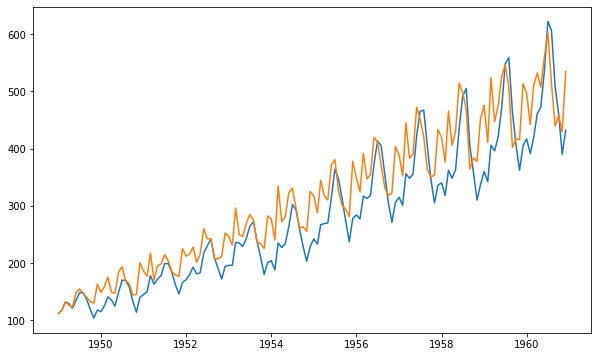

In [38]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexed_dataset)
plt.plot(predictions_ARIMA)

## Getting the dataset size before prediction

In [39]:
indexed_dataset_log_scale

,Passengers
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791
...,...
1960-08-01,6.406880
1960-09-01,6.230481
1960-10-01,6.133398


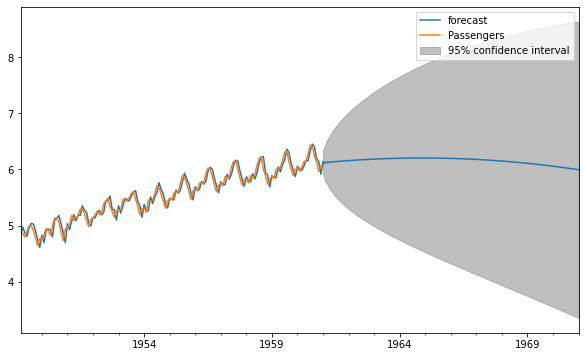

In [54]:
results_ARIMA.plot_predict(2,264)
x = results_ARIMA.forecast(steps=120)  # result in array format